In [75]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from datetime import date,datetime,timedelta

In [76]:
INDEX = ['^N225', '^HSI', '^DJI', '000001.SS']
DEG = 2 #use [2,3,4]
start_date = '2016-01-01'
end_date = '2020-11-01'
scaler = MinMaxScaler((0,1))
start_date = datetime.strptime(start_date, "%Y-%m-%d")
end_date = datetime.strptime(end_date, "%Y-%m-%d")

In [77]:
def prepare_index(INDEX_NAME, start_date, end_date):
    index = pdr.get_data_yahoo(INDEX_NAME, start=start_date, end=end_date)
    index = index[['Close','High','Low','Volume','Open']]
    index.reset_index(inplace=True)
    index = macd(index, 12, 26, 9) #fast=12 slow=26 signal=9
    index = rsi(index, 14) #time=14
    index = ema(index, 14) #time=14
    index = stoch(index) 
    index = obv(index) 
    index = ad(index)
    index = adx(index, 14) #time=14
    index = sma(index, 14) #time=14
    index = cmo(index, 14) #time=14
    index = cci(index, 14) #time=14
    index = index[['Date','Close','macd','RSI','STOCH_slowk','EMA','OBV','ADLine','ADX','SMA','CMO','CCI']]
    index.set_index("Date", inplace=True)
    index = index.bfill(axis ='rows')

    return index

def target(df, col="Close", shift=-1, sideway=0):
    return df.assign(Target = np.where( df[col].shift(shift) > df[col] * (1 + sideway), 1, 0))

def macd(idx, fast, slow, signal):
    macd, macdsignal, macdhist = talib.MACD(idx['Close'], fastperiod=fast, slowperiod=slow, signalperiod=signal)
    d = pd.DataFrame(macd)
    d = d.assign(signal=macdsignal)
    d = d.rename({0:'macd'},axis=1)
    idx = idx.assign(macd=d['macd'])
    return idx

def rsi(idx, time):
    RSI= talib.RSI(idx['Close'],timeperiod=time)
    RSI = RSI.to_frame()
    RSI = RSI.rename({0:'RSI'},axis=1)
    idx = idx.assign(RSI=RSI['RSI'])
    return idx

def ema(idx, time):
    real = talib.EMA(idx['Close'], timeperiod=time)
    idx = idx.assign(EMA=real)
    return idx

def stoch(idx):
    slowk, slowd = talib.STOCH(idx['High'], idx['Low'], idx['Close'])
    idx = idx.assign(STOCH_slowk=slowk)
    return idx

def obv(idx):
    real = talib.OBV(idx['Close'], idx['Volume'])
    idx = idx.assign(OBV=real)
    return idx

def ad(idx):
    real = talib.AD(idx['High'], idx['Low'], idx['Close'], idx['Volume'])
    idx = idx.assign(ADLine=real)
    return idx

def adx(idx, time):
    real = talib.ADX(idx['High'], idx['Low'], idx['Close'], timeperiod=time)
    idx = idx.assign(ADX=real)
    return idx

def aroon(idx, time):
    aroondown, aroonup = talib.AROON(idx['High'], idx['Low'], timeperiod=time)
    
def sma(idx, time):
    real = talib.SMA(idx['Close'], timeperiod=time)
    idx = idx.assign(SMA=real)
    return idx

def cmo(idx, time):
    real = talib.CMO(idx['Close'], timeperiod=time)
    idx = idx.assign(CMO=real)
    return idx

def cci(idx, time):
    real = talib.CCI(idx['High'], idx['Low'], idx['Close'], timeperiod=time)
    idx = idx.assign(CCI=real)
    return idx

In [78]:
selected_features = ['macd', 'RSI', 'EMA', 'ADLine', 'CMO', 'CCI']
shift_list = [1,3,7,10,30,60,90]

In [79]:
model = {}
stat_result = pd.DataFrame(columns=["Index", "Shift", "MAE", "RMSE", "R2"])
df_result = {}
poly_feature = PolynomialFeatures(degree=DEG)
for shift in shift_list:
    model[shift] = LinearRegression()
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    for name in INDEX:
        index = prepare_index(name, start_date=start_date, end_date=end_date)
        X = np.array(index.iloc[:-shift,:][selected_features])
        y = np.array(index.iloc[shift:,:]["Close"]).reshape((-1,1))
        X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)
        X_train[name] = scaler.fit_transform(X_train[name])
        X_test[name] = scaler.transform(X_test[name])
        y_train[name] = scaler.fit_transform(y_train[name])
        y_test[name] = scaler.transform(y_test[name])
        X_train[name] = poly_feature.fit_transform(X_train[name])
        X_test[name] = poly_feature.fit_transform(X_test[name])
        model[shift].fit(X_train[name], y_train[name])

    for name in INDEX:
        pred = model[shift].predict(X_test[name])
        stat_result = stat_result.append({
            "Index" : name,
            "Shift" : shift,
            "MAE" : mean_absolute_error(y_test[name], pred),
            "RMSE" : mean_squared_error(y_test[name], pred, squared=False),
            "R2" : r2_score(y_test[name], pred),
        }, ignore_index=True)
        df_result[name + "-" + str(shift)] = pd.DataFrame({"Actual": y_test[name].ravel(), "Predict" : pred.ravel()})
# stat_result.set_index(["Index", "Shift"],inplace=True)
stat_result


,Index,Shift,MAE,RMSE,R2
0,^N225,1,0.069112,0.081564,0.814633
1,^HSI,1,0.041448,0.049283,0.793417
2,^DJI,1,0.103738,0.157113,0.318900
3,000001.SS,1,0.042268,0.055584,0.916517
4,^N225,3,0.099301,0.117811,0.613263
5,^HSI,3,0.077942,0.088532,0.334555
6,^DJI,3,0.134478,0.217292,-0.318910
7,000001.SS,3,0.084912,0.104859,0.703611
8,^N225,7,0.172788,0.197917,-0.089312
9,^HSI,7,0.124093,0.137825,-0.612755


In [80]:
evaluated = {}
for name in INDEX:
    evaluated[name] = stat_result[stat_result["Index"] == name].set_index("Shift")[["RMSE","R2"]]

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/3030396708.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


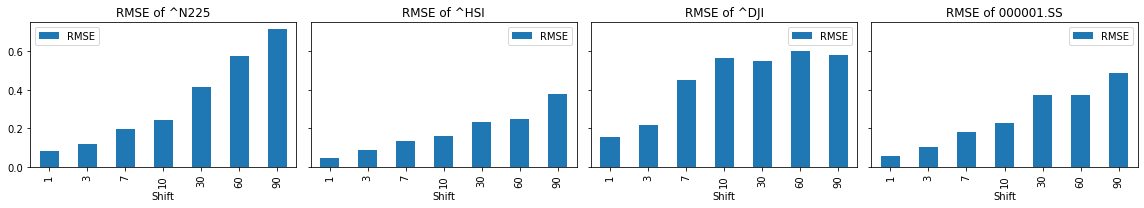

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=len(INDEX), figsize=(16,3), sharey=True)
i = 0
for name in INDEX:
    evaluated[name][["RMSE"]].plot.bar(ax=axes[i], title="RMSE of " + name)
    i += 1

fig.tight_layout()
fig.show()

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/4207630787.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


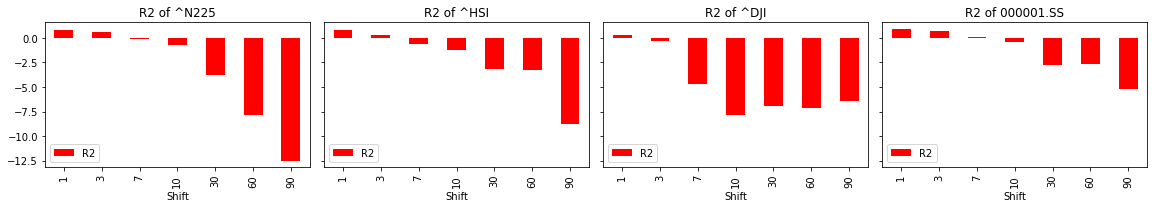

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=len(INDEX), figsize=(16,3), sharey=True)
i = 0
for name in INDEX:
    evaluated[name][["R2"]].plot.bar(ax=axes[i], title="R2 of " + name, color="r")
    i += 1

fig.tight_layout()
fig.show()

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/2417097605.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


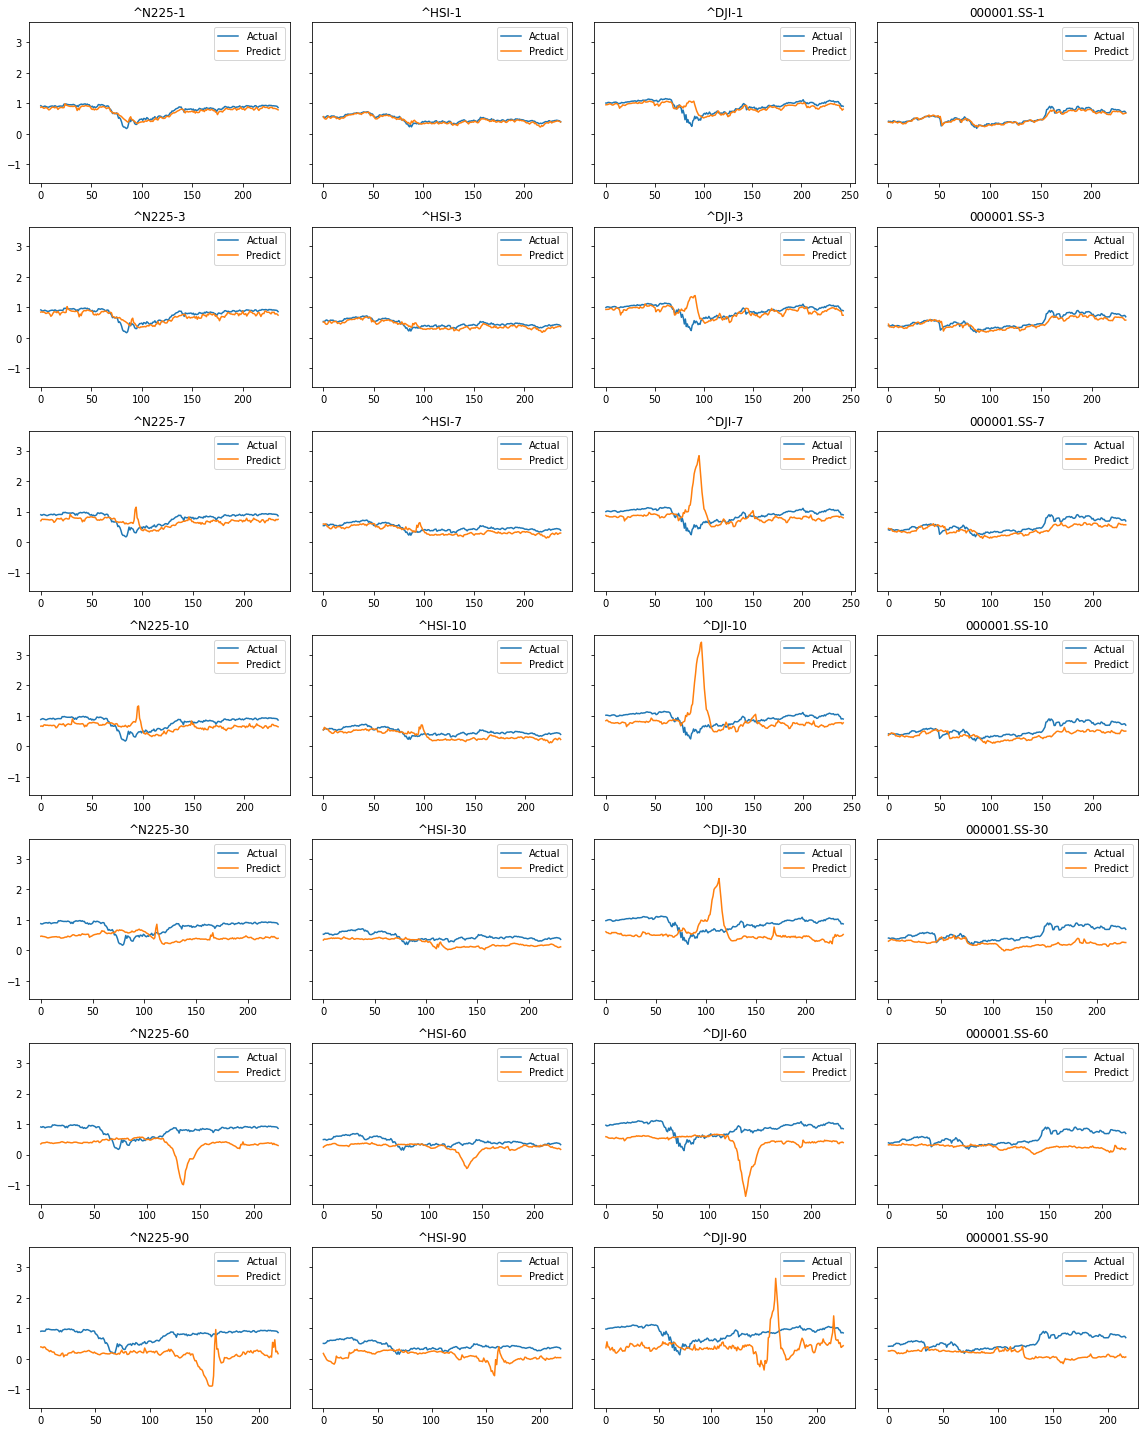

In [83]:
fig, axes = plt.subplots(nrows=len(shift_list), ncols=len(INDEX), figsize=(16,20), sharey=True)
i = 0
for shift in shift_list:
    j = 0
    for name in INDEX:
        key = name + "-" + str(shift)
        df_result[key].plot(ax=axes[i, j], title=key)
        j += 1
    i += 1
fig.tight_layout()
fig.show()

In [84]:
unseen_start_date = '2020-11-18'
unseen_end_date = '2021-08-19'
unseen_start_date = datetime.strptime(unseen_start_date, "%Y-%m-%d")
unseen_end_date = datetime.strptime(unseen_end_date, "%Y-%m-%d")

In [85]:
stat_result = pd.DataFrame(columns=["Index", "Shift", "MAE", "RMSE", "R2"])
df_result = {}
for shift in shift_list:
    for name in INDEX:
        index = prepare_index(name, start_date=unseen_start_date, end_date=unseen_end_date + timedelta(days=shift))
        X = np.array(index.iloc[:-shift,:][selected_features])
        ori = np.array(index.iloc[:-shift,:]["Close"]).reshape((-1,1))
        y = np.array(index.iloc[shift:,:]["Close"]).reshape((-1,1))
        X_future = scaler.fit_transform(X)
        y_future = scaler.fit_transform(y)
        ori = scaler.transform(ori)
        X_future = poly_feature.fit_transform(X_future)
        pred = model[shift].predict(X_future)
        stat_result = stat_result.append({
            "Index" : name,
            "Shift" : shift,
            "MAE" : mean_absolute_error(y_future, pred),
            "RMSE" : mean_squared_error(y_future, pred, squared=False),
            "R2" : r2_score(y_future, pred),
        }, ignore_index=True)
        df_result[name + "-" + str(shift)] = pd.DataFrame({ "Actual": y_future.ravel(), 
                                                            "Predict" : pred.ravel(),
                                                            "Origin" : ori.ravel()
                                                            })
# stat_result.set_index(["Index", "Shift"],inplace=True)
stat_result

,Index,Shift,MAE,RMSE,R2
0,^N225,1,0.064437,0.084606,0.846593
1,^HSI,1,0.074988,0.093550,0.791661
2,^DJI,1,0.034477,0.043759,0.977795
3,000001.SS,1,0.130368,0.166987,0.461312
4,^N225,3,0.121978,0.152258,0.595796
5,^HSI,3,0.091174,0.112678,0.695002
6,^DJI,3,0.057079,0.071801,0.938757
7,000001.SS,3,0.157585,0.203807,0.184817
8,^N225,7,0.182750,0.223343,0.173155
9,^HSI,7,0.096660,0.126103,0.641105


In [86]:
evaluated = {}
for name in INDEX:
    evaluated[name] = stat_result[stat_result["Index"] == name].set_index("Shift")[["RMSE","R2"]]

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/3030396708.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


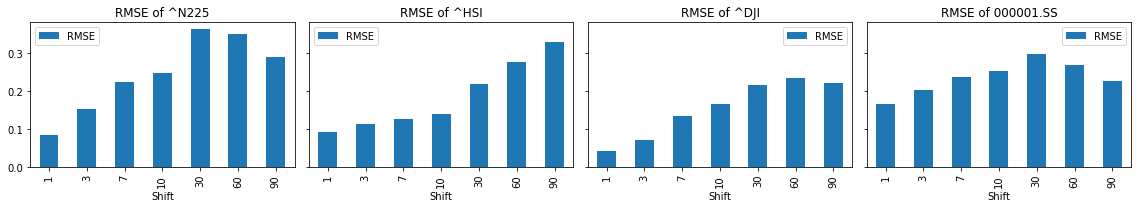

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=len(INDEX), figsize=(16,3), sharey=True)
i = 0
for name in INDEX:
    evaluated[name][["RMSE"]].plot.bar(ax=axes[i], title="RMSE of " + name)
    i += 1

fig.tight_layout()
fig.show()

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/4207630787.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


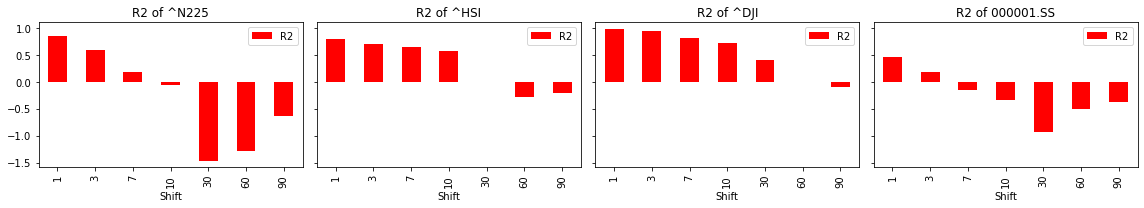

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=len(INDEX), figsize=(16,3), sharey=True)
i = 0
for name in INDEX:
    evaluated[name][["R2"]].plot.bar(ax=axes[i], title="R2 of " + name, color="r")
    i += 1

fig.tight_layout()
fig.show()

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/4114350723.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


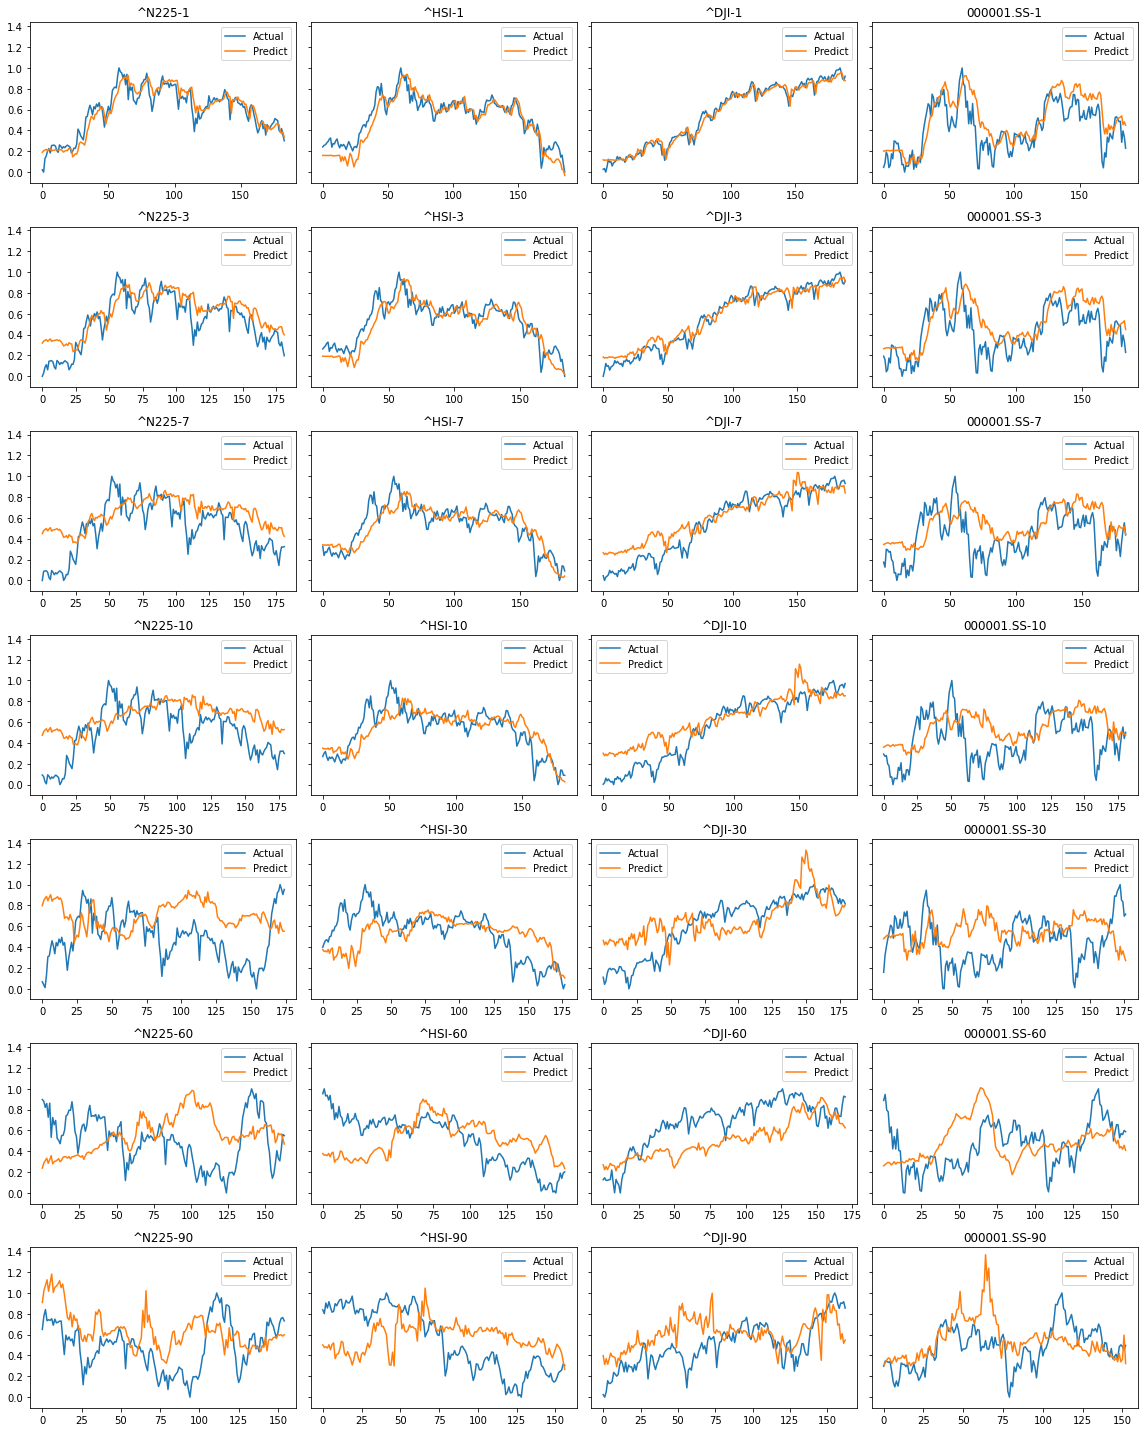

In [89]:
fig, axes = plt.subplots(nrows=len(shift_list), ncols=len(INDEX), figsize=(16,20), sharey=True)
i = 0
for shift in shift_list:
    j = 0
    for name in INDEX:
        key = name + "-" + str(shift)
        df_result[key][["Actual", "Predict"]].plot(ax=axes[i, j], title=key)
        j += 1
    i += 1
fig.tight_layout()
fig.show()

In [90]:
acc_obj = {}
acc_scores = pd.DataFrame(columns=["Shift", "Accuracy"])
unseen_target = {}
for shift in shift_list:
    for name in INDEX:
        key = name + "-" + str(shift)
        df_result[key]["Target"] = np.where(df_result[key]["Actual"] > df_result[key]["Origin"], 1, 0)
        df_result[key]["Predict Target"] = np.where(df_result[key]["Predict"] > df_result[key]["Origin"], 1, 0)
        acc_target = df_result[key]["Target"]
        pred_target = df_result[key]["Predict Target"]
        acc_scores = acc_scores.append({
            "Index" : name,
            "Shift" : shift,
            "Accuracy" : accuracy_score(acc_target, pred_target)
        }, ignore_index=True)
        acc_obj[name] = acc_scores[acc_scores["Index"] == name][["Shift", "Accuracy"]]

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_6992/111024884.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


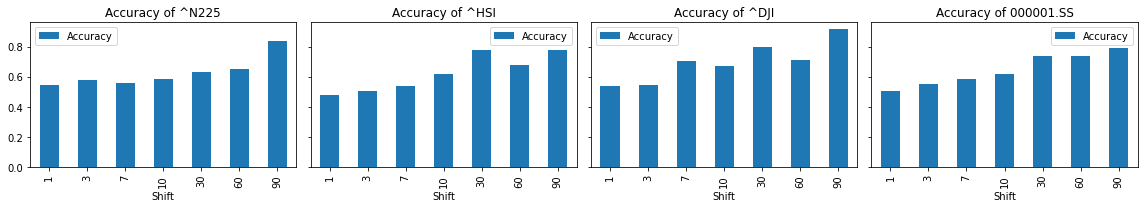

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=len(INDEX), figsize=(16,3), sharey=True)
i = 0
for name in INDEX:
    acc_obj[name] = acc_obj[name].set_index("Shift")
    acc_obj[name].plot.bar(ax=axes[i], title="Accuracy of " + name)
    i += 1

fig.tight_layout()
fig.show()